In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.8 MB/s eta 0:00:00


In [ ]:
import os
import tensorflow as tf
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from mtcnn import MTCNN

TRAIN_DATA_DIR = "/content/image_data/VGG-Face2_sampled/train"
TEST_DATA_DIR = "/content/image_data/VGG-Face2_sampled/test"

## If using Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/VGG-Face2_sampled.zip -d /content/image_data

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0470_01.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0542_02.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0547_05.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0572_01.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0610_01.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0643_01.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0659_01.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0688_01.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0689_04.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0766_01.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0787_03.jpg  
  inflating: /content/image_data/VGG-Face2_sampled/train/n009136/0

## Basic information

In [ ]:
print(f"Train dataset classes: {len(os.listdir(TRAIN_DATA_DIR))}")
print(f"Test dataset classes: {len(os.listdir(TEST_DATA_DIR))}")

total_image_count_train = 0
image_count_per_person_train = []
for person in os.listdir(TRAIN_DATA_DIR):
    img_count = len(os.listdir(os.path.join(TRAIN_DATA_DIR, person)))
    total_image_count_train += img_count
    image_count_per_person_train.append(img_count)

print("\nTrain:")
print(f"Average images per person: {sum(image_count_per_person_train) / len(image_count_per_person_train)}")
print(f"min images per person: {min(image_count_per_person_train)}")
print(f"max images per person: {max(image_count_per_person_train)}")
print(f"Total images: {total_image_count_train}")

total_image_count_test = 0
image_count_per_person_test = []
for person in os.listdir(TEST_DATA_DIR):
    img_count = len(os.listdir(os.path.join(TEST_DATA_DIR, person)))
    total_image_count_test += img_count
    image_count_per_person_test.append(img_count)

print("\nTest:")
print(f"Average images per person: {sum(image_count_per_person_test) / len(image_count_per_person_test)}")
print(f"min images per person: {min(image_count_per_person_test)}")
print(f"max images per person: {max(image_count_per_person_test)}")
print(f"Total images: {total_image_count_test}")

Train dataset classes: 8631
Test dataset classes: 500

Train:
Average images per person: 36.45614644884718
min images per person: 9
max images per person: 90
Total images: 314653

Test:
Average images per person: 338.792
min images per person: 98
max images per person: 761
Total images: 169396


In [ ]:
image_widths = []
image_heights = []
nonRGB = 0

for person in tqdm(os.listdir(TRAIN_DATA_DIR)):
  for image in os.listdir(os.path.join(TRAIN_DATA_DIR, person)):
    image_shape = tf.image.decode_jpeg(tf.io.read_file(os.path.join(TRAIN_DATA_DIR, person, image))).shape
    image_widths.append(image_shape[0])
    image_heights.append(image_shape[1])
    nonRGB += 1 if len(image_shape) != 3 else 0

100%|██████████| 8631/8631 [05:56<00:00, 24.24it/s]


In [ ]:
print(f"Average width: {sum(image_widths) / len(image_widths)}")
print(f"Average height: {sum(image_heights) / len(image_heights)}")
print(f"Min width: {min(image_widths)}")
print(f"Min height: {min(image_heights)}")
print(f"Max width: {max(image_widths)}")
print(f"Max height: {max(image_heights)}")

image_size = np.array(image_widths) * np.array(image_heights)
largest = np.argwhere(image_size == image_size.max())[0][0]
smallest = np.argwhere(image_size == image_size.min())[0][0]
print(f"Largest image: {image_widths[largest]}x{image_heights[largest]}")
print(f"Smallest image: {image_widths[smallest]}x{image_heights[smallest]}")
print(f"Non RGB images: {nonRGB}")

Average width: 257.89933355156313
Average height: 240.99821390547683
Min width: 36
Min height: 33
Max width: 3456
Max height: 4831
Largest image: 2916x4831
Smallest image: 36x33
Non RGB images: 0


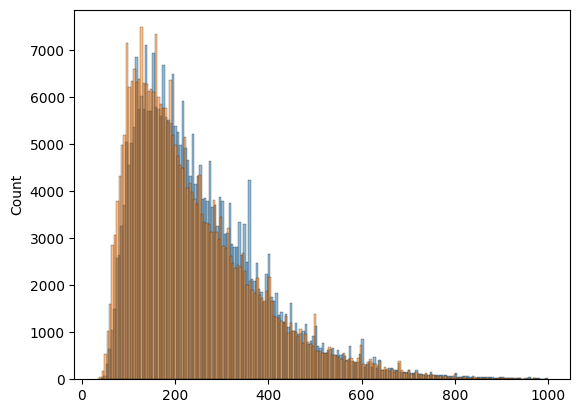

In [ ]:
image_widths = np.array(image_widths)
image_heights = np.array(image_heights)
sns.histplot(image_widths[image_widths < 1000], alpha=0.5)
sns.histplot(image_heights[image_heights < 1000], alpha=0.5)
plt.show()

## Initial exploration

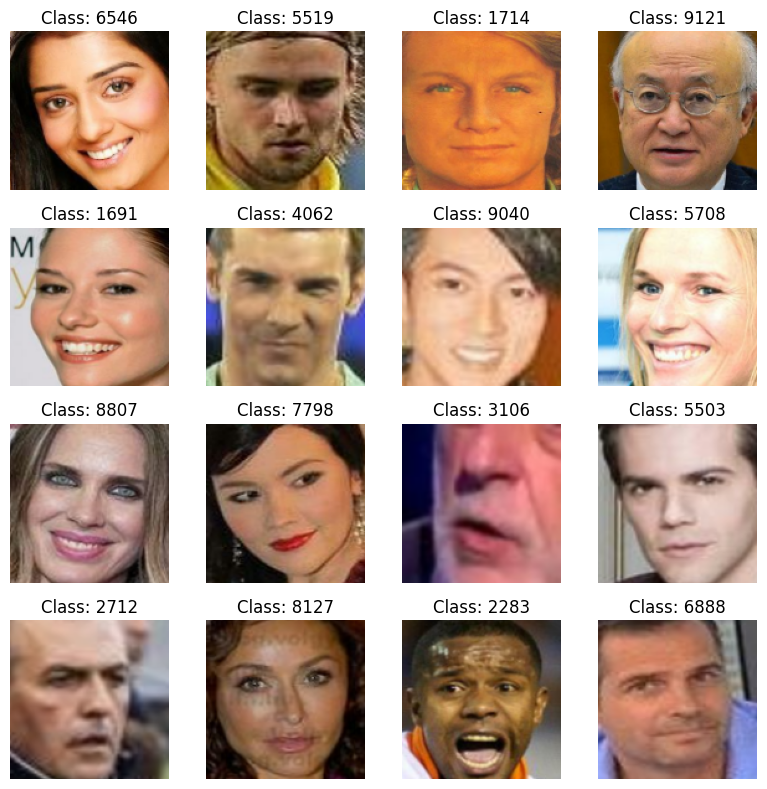

In [ ]:
tf.random.set_seed(42)

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [256, 256])
    return img, image_path

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_face(image_tensor):
    img_np = image_tensor.numpy()
    img_np = (img_np * 255).astype('uint8')

    gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    face = faces[0] if len(faces) > 0 else None
    if face is not None:
        x, y, w, h = face
        img_face = img_np[y:y+h, x:x+w]
        img_face = cv2.resize(img_face, (128, 128))
        return tf.convert_to_tensor(img_face), tf.constant(True, dtype=tf.bool)
    else:
        return tf.zeros([128, 128, 3], dtype=tf.uint8), tf.constant(False, dtype=tf.bool)

def class_from_path(image_path):
    return int(os.path.basename(os.path.dirname(image_path.numpy()))[1:])

def is_valid_face(face_detected):
    return face_detected

train_image_paths = []
for person in os.listdir(TRAIN_DATA_DIR):
    for image_file in os.listdir(os.path.join(TRAIN_DATA_DIR, person)):
        train_image_paths.append(os.path.join(TRAIN_DATA_DIR, person, image_file))

ds_train = tf.data.Dataset.from_tensor_slices(train_image_paths)
ds_train = ds_train.shuffle(buffer_size=len(train_image_paths), reshuffle_each_iteration=False)
ds_train = ds_train.map(load_and_preprocess_image)
ds_face_train = ds_train.map(lambda image, path: (*tf.py_function(detect_face, [image], [tf.uint8, tf.bool]),
                                                  tf.py_function(class_from_path, [path], tf.int32)))

ds_face_train = ds_face_train.filter(lambda image, face_detected, class_number: tf.py_function(is_valid_face, [face_detected], tf.bool))
ds_face_train = ds_face_train.map(lambda image, face_detected, class_number: (image, class_number))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, (image, class_number) in enumerate(ds_face_train.take(16)):
    axs[i // 4, i % 4].imshow(image)
    axs[i // 4, i % 4].set_title(f"Class: {class_number}")
    axs[i // 4, i % 4].axis('off')
plt.tight_layout()
plt.show()

Unsatisfactory performance form Haar's Cascade. Will instead use MTCNN

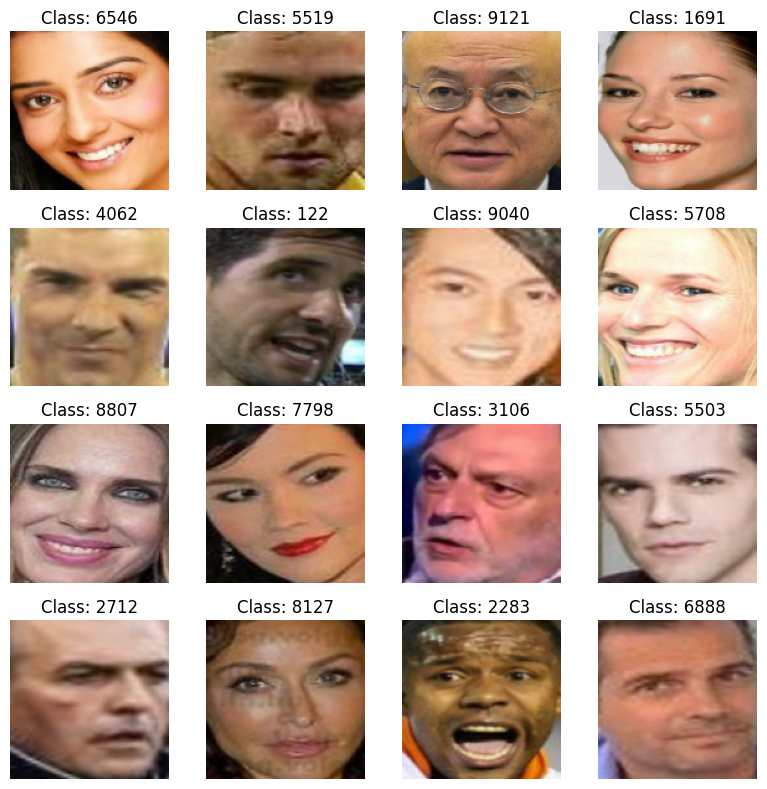

In [ ]:
tf.random.set_seed(42)
DETECTOR = MTCNN()

def detect_face_mtcnn(image_tensor):
    img_np = image_tensor.numpy()
    img_np = (img_np * 255).astype('uint8')
    img_np_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    faces = DETECTOR.detect_faces(img_np_bgr)
    if faces and len(faces) > 0:
        x, y, width, height = faces[0]['box']
        x2, y2 = x + width, y + height
        img_face = img_np[y:y2, x:x2]
        img_face = cv2.resize(img_face, (128, 128))
        return tf.convert_to_tensor(img_face), tf.constant(True, dtype=tf.bool)
    else:
        return tf.zeros([128, 128, 3], dtype=tf.uint8), tf.constant(False, dtype=tf.bool)

ds_face_train = ds_train.map(lambda image, path: (*tf.py_function(detect_face_mtcnn, [image], [tf.uint8, tf.bool]),
                                                  tf.py_function(class_from_path, [path], tf.int32)))

ds_face_train = ds_face_train.filter(lambda image, face_detected, class_number: tf.py_function(is_valid_face, [face_detected], tf.bool))
ds_face_train = ds_face_train.map(lambda image, face_detected, class_number: (image, class_number))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, (image, class_number) in enumerate(ds_face_train.take(16)):
    axs[i // 4, i % 4].imshow(image)
    axs[i // 4, i % 4].set_title(f"Class: {class_number}")
    axs[i // 4, i % 4].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def detect_face_mtcnn(image_tensor):
    img_np = image_tensor.numpy()
    img_np = (img_np * 255).astype('uint8')
    img_np_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    faces = DETECTOR.detect_faces(img_np_bgr)
    if faces and len(faces) > 0:
        x, y, width, height = faces[0]['box']
        x2, y2 = x + width, y + height
        img_face = img_np[y:y2, x:x2]
        img_face = cv2.resize(img_face, (128, 128))
        return tf.convert_to_tensor(img_face), tf.constant(True, dtype=tf.bool)
    else:
        return tf.zeros([128, 128, 3], dtype=tf.uint8), tf.constant(False, dtype=tf.bool)

# ds_face_train = ds_train.map(lambda image, path: (*tf.py_function(detect_face_mtcnn, [image], [tf.uint8, tf.bool]),
#                                                   tf.py_function(class_from_path, [path], tf.int32)))

Way more satisfactory result.

## Preprocessing

In [ ]:
def load_and_preprocess_dataset(data_dir, max_person, max_images_per_person):
    image_paths = []
    person_count = 0
    for person in os.listdir(data_dir):
        if person_count >= max_person:
            break
        person_count += 1
        image_count = 0
        for image_file in os.listdir(os.path.join(data_dir, person)):
            if image_count >= max_images_per_person:
                break
            image_paths.append(os.path.join(data_dir, person, image_file))
            image_count += 1

    ds = tf.data.Dataset.from_tensor_slices(image_paths)
    # ds = ds.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=False)
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds_face = ds.map(lambda image, path: (*tf.py_function(detect_face_mtcnn, [image], [tf.uint8, tf.bool]),
                                                    tf.py_function(class_from_path, [path], tf.int32)),
                     num_parallel_calls=tf.data.AUTOTUNE)

    ds_face = ds_face.filter(lambda image, face_detected, class_number: tf.py_function(is_valid_face, [face_detected], tf.bool))
    ds_face = ds_face.map(lambda image, face_detected, class_number: (image, class_number))
    ds_face = ds_face.map(lambda image, class_number: (image / 255, class_number))

    ds_face = ds_face.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds_face

In [ ]:
def save_as_jpeg(dataset, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, (image, label) in tqdm(enumerate(dataset)):
        class_dir = os.path.join(save_dir, str(label.numpy()))
        os.makedirs(class_dir, exist_ok=True)
        filename = os.path.join(class_dir, f'{i}.jpg')
        image_np = image.numpy()
        tf.keras.utils.save_img(filename, image_np)

In [ ]:
print("Processing test")
test_ds = load_and_preprocess_dataset(TEST_DATA_DIR, max_person=500, max_images_per_person=15)
save_as_jpeg(test_ds, '/content/test_data')
!zip -r /content/test_data.zip /content/test_data
!mv /content/test_data.zip /content/drive/MyDrive/

print("Processing train")
train_ds = load_and_preprocess_dataset(TRAIN_DATA_DIR, max_person=3000, max_images_per_person=15)
save_as_jpeg(train_ds, '/content/train_data')
!zip -r /content/train_data.zip /content/train_data

!mv /content/train_data.zip /content/drive/MyDrive/

Processing train


38270it [2:24:56,  4.40it/s]


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  adding: content/train_data/87/37519.jpg (deflated 5%)
  adding: content/train_data/87/37520.jpg (deflated 5%)
  adding: content/train_data/87/37524.jpg (deflated 4%)
  adding: content/train_data/87/37521.jpg (deflated 4%)
  adding: content/train_data/6435/ (stored 0%)
  adding: content/train_data/6435/31431.jpg (deflated 4%)
  adding: content/train_data/6435/31432.jpg (deflated 4%)
  adding: content/train_data/6435/31430.jpg (deflated 5%)
  adding: content/train_data/6435/31434.jpg (deflated 4%)
  adding: content/train_data/6435/31433.jpg (deflated 4%)
  adding: content/train_data/6435/31423.jpg (deflated 5%)
  adding: content/train_data/6435/31428.jpg (deflated 5%)
  adding: content/train_data/6435/31426.jpg (deflated 5%)
  adding: content/train_data/6435/31424.jpg (deflated 5%)
  adding: content/train_data/6435/31421.jpg (deflated 5%)
  adding: content/train_data/6435/31422.jpg (deflated 4%)
  adding: content/train_da

In [ ]:
# !zip -r /content/train_data.zip /content/train_data
# !zip -r /content/test_data.zip /content/test_data

# !mv /content/train_data.zip /content/drive/MyDrive/
# !mv /content/test_data.zip /content/drive/MyDrive/